In [46]:
# The numerical integrators are located in a module two levels above
# the current working directory. Hence:
import sys
sys.path.insert(0, '../..')

# Package imports

In [47]:
import matplotlib as mpl

mpl.use("pgf")

## TeX preamble
preamble = [
    r'\usepackage{fontspec}',
    r'\setmainfont{Linux Libertine O}',
]

params = {
    'font.family': 'serif',
    'text.usetex': True,
    'text.latex.unicode': True,
    'pgf.rcfonts': False,
    'pgf.texsystem': 'xelatex',
    'pgf.preamble': preamble,
}

mpl.rcParams.update(params)

/home/arne/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
# Numpy
import numpy as np

# Matplotlib
from matplotlib import pyplot as plt
plt.rc('text',usetex=True)
plt.rc('figure',figsize=(18,10),dpi=100)
%matplotlib inline

# Numba (JiT)
from numba import njit

# (Primitive) timing functionality
import time 

# Multiprocessing:
import multiprocessing as mp

# Spline interpolation:
from scipy.interpolate import RectBivariateSpline

# Check whether folders exist or not, necessary
# for storing advected states:
import os
import errno

# Display progress bars:
from ipywidgets import FloatProgress
from IPython.display import display

# Function that creates directories if they don't exist

In [4]:
# Function that makes a directory if it does not exist,
# and raises an exception otherwise 
# (necessary for storing advected states)

def ensure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

# Set of implemented fixed step integrators
## Important for saving/loading states

In [5]:
fixed_step_integrators = set(['euler','rk2','rk3','rk4'])

# Function that generates an extended grid of tracers

In [6]:
def padded_grid_of_particles(nx,ny,x_min,x_max,y_min,y_max):
    x_0,dx = np.linspace(x_min,x_max,nx,retstep=True)
    y_0,dy = np.linspace(y_min,y_max,ny,retstep=True)
    
    x = np.empty(nx+4)
    x[0:2] = -2*dx, -dx
    x[2:-2] = x_0
    x[-2:] = x_max+dx, x_max+2*dx
    
    y = np.empty(ny+4)
    y[0:2] = -2*dy, -dy
    y[2:-2] = y_0
    y[-2:] = y_max+dy, y_max+2*dy
    
    nx_ = nx+4
    ny_ = ny+4
    
    grid = np.empty((2,nx_*ny_))
    
    for j in range(nx_):
        grid[0,j*ny_:(j+1)*ny_] = x[j]
        grid[1,j*ny_:(j+1)*ny_] = y
    
    return grid   

# Function which calculates characteristics

In [7]:
def characteristics(t_start,t_end,nx,ny,x_min,x_max,y_min,y_max,integrator,stride,n_proc=4,atol=None,rtol=None):
    if atol is None:
        atol = 1.e-9
    if rtol is None:
        rtol = 1.e-9
    
    #grid = padded_grid_of_particles(nx,ny,x_min,x_max,y_min,y_max)
    dx_main = (x_max-x_min)/(nx-1)
    dy_main = (y_max-y_min)/(ny-1)
    
    dx_aux = np.minimum(1e-5,dx_main*1e-2)
    dy_aux = np.minimum(1e-5,dy_main*1e-2)
    
    _inner_mask = np.zeros((nx+4,ny+4),dtype=np.bool)
    _inner_mask[2:-2,2:-2] = True
    _inner_mask=_inner_mask.reshape((nx+4)*(ny+4))
    
    grid_fin,lmbd1,lmbd2,hess_lmbd2,xi1,xi2 = _characteristics(t_start,t_end,nx,ny,x_min,x_max,y_min,y_max,dx_main,dy_main,dx_aux,dy_aux,integrator,stride,n_proc,atol,rtol)
    
    return grid_fin[:,_inner_mask],lmbd1[_inner_mask],lmbd2[_inner_mask],hess_lmbd2[_inner_mask],xi1[_inner_mask,:],xi2[_inner_mask,:]

def _characteristics(t_start,t_end,nx,ny,x_min,x_max,y_min,y_max,dx_main,dy_main,dx_aux,dy_aux,integrator,stride,n_proc,atol,rtol):
    if integrator.__name__ in fixed_step_integrators:
        try:
            grid = np.load('precomputed_advection/{}/advected_grid_Nx={}_Ny={}_dx_main={}_dy_main={}_dx_aux={}_dy_aux={}_t_start={}_t_end={}_h={}.npy'.format(integrator.__name__,nx,ny,dx_main,dy_main,dx_aux,dy_aux,t_start,t_end,stride))
            print('Precomputed advection found! Advection not necessary!')
        except IOError:
            print('Precomputed advection not found!')
    else:
        try:
            grid = np.load('precomputed_advection/{}/advected_grid_Nx={}_Ny={}_dx_main={}_dy_main={}_dx_aux={}_dy_aux={}_t_start={}_t_end={}_atol={}_rtol={}.npy'.format(integrator.__name__,nx,ny,dx_main,dy_main,dx_aux,dy_aux,t_start,t_end,atol,rtol))
            print('Precomputed advection found! Advection not necessary!')
        except IOError:
            print('Precomputed advection not found!')
    
    tic = time.time()                              
    
    tens_main,tens_aux = _find_strain_tensors(grid,nx,ny,dx_main,dy_main,dx_aux,dy_aux)
    
    lmbd1,lmbd2,xi1,xi2 = _find_characteristics(tens_main,tens_aux)
    
    hess_lmbd2 = _find_hessian(lmbd2,nx,ny,dx_main,dy_main)
                
    mins,secs = np.divmod(time.time()-tic,60)
    
    print('Characteristics calculated in {} minutes and {} seconds'.format(mins,secs))        
    
    return grid[0],lmbd1,lmbd2,hess_lmbd2,xi1,xi2

def _find_strain_tensors(grid,nx,ny,dx_main,dy_main,dx_aux,dy_aux):
    grid_main = grid[0].reshape((2,nx+4,ny+4))
    grid_right = grid[1].reshape((2,nx+4,ny+4))
    grid_top = grid[2].reshape((2,nx+4,ny+4))
    grid_left = grid[3].reshape((2,nx+4,ny+4))
    grid_btm = grid[4].reshape((2,nx+4,ny+4))
    
    # Declare Jacobians
    df_m = np.empty((nx+4,ny+4,2,2))
    df_a = np.empty((nx+4,ny+4,2,2))
    
    # Use centered differencing throughout for auxiliary Jacobian:
    df_a[:,:,0,0] = (grid_right[0]-grid_left[0])/(2*dx_aux)
    df_a[:,:,0,1] = (grid_top[0]-grid_btm[0])/(2*dy_aux)
    df_a[:,:,1,0] = (grid_right[1]-grid_left[1])/(2*dx_aux)
    df_a[:,:,1,1] = (grid_top[1]-grid_btm[1])/(2*dy_aux)
    
    # Use centered differencing where applicable for main Jacobian,
    # second order backwards/forwards difference otherwise
    df_m[1:-1,:,0,0] = (grid_main[0,2:,:]-grid_main[0,0:-2,:])/(2*dx_main)
    df_m[0,:,0,0] = (-3*grid_main[0,0,:]+4*grid_main[0,1,:]-2*grid_main[0,2,:])/(2*dx_main)
    df_m[-1,:,0,0] = (3*grid_main[0,-1,:]-4*grid_main[0,-2,:]+2*grid_main[0,-3,:])/(2*dx_main)
    
    df_m[:,1:-1,0,1] = (grid_main[0,:,2:]-grid_main[0,:,0:-2])/(2*dy_main)
    df_m[:,0,0,1] = (-3*grid_main[0,:,0]+4*grid_main[0,:,1]-2*grid_main[0,:,2])/(2*dy_main)
    df_m[:,-1,0,1] = (3*grid_main[0,:,-1]-4*grid_main[0,:,-2]+2*grid_main[0,:,-3])/(2*dy_main)
    
    df_m[1:-1,:,1,0] = (grid_main[1,2:,:]-grid_main[1,0:-2,:])/(2*dx_main)
    df_m[0,:,1,0] = (-3*grid_main[1,0,:]+4*grid_main[1,1,:]-2*grid_main[1,2,:])/(2*dx_main)
    df_m[-1,:,1,0] = (3*grid_main[1,-1,:]-4*grid_main[1,-2,:]+2*grid_main[1,-3,:])/(2*dx_main)
    
    df_m[:,1:-1,1,1] = (grid_main[1,:,2:]-grid_main[1,:,0:-2])/(2*dy_main)
    df_m[:,0,1,1] = (-3*grid_main[1,:,0]+4*grid_main[1,:,1]-2*grid_main[1,:,2])/(2*dy_main)
    df_m[:,-1,1,1] = (3*grid_main[1,:,-1]-4*grid_main[1,:,-2]+2*grid_main[1,:,-3])/(2*dy_main)
    
    # Reshape Jacobian arrays:
    df_a = df_a.reshape(((nx+4)*(ny+4),2,2))
    df_m = df_m.reshape(((nx+4)*(ny+4),2,2))
    
    # Calculate strain tensors:
    c_m = np.matmul(np.transpose(df_m,axes=(0,2,1)),df_m)
    c_a = np.matmul(np.transpose(df_a,axes=(0,2,1)),df_a)
        
    return c_m,c_a

def _find_characteristics(tens_main,tens_aux):
    
    vals = np.linalg.eigvalsh(tens_main)
    bar, vecs = np.linalg.eigh(tens_aux)
    
    lmbd1 = vals[:,0]
    lmbd2 = vals[:,1]
    
    xi1 = vecs[:,:,0]
    xi2 = vecs[:,:,1]
    
    return lmbd1,lmbd2,xi1,xi2

def _find_hessian(lmbd_,nx,ny,dx_main,dy_main):
    lmbd = lmbd_.reshape((nx+4,ny+4))
    
    hessian = np.empty((nx+4,ny+4,2,2))
    
    # First, the laplacian terms:
    
    # Internal points: Centered differences
    hessian[1:-1,:,0,0] = (lmbd[2:,:]-2*lmbd[1:-1,:]+lmbd[:-2,:])/(dx_main**2)
    hessian[:,1:-1,1,1] = (lmbd[:,2:]-2*lmbd[:,1:-1]+lmbd[:,:-2])/(dy_main**2)
    
    # Near boundaries: Higher order forwards/backwards differences
    hessian[0,:,0,0] = (2*lmbd[0,:]-5*lmbd[1,:]+4*lmbd[2,:]-lmbd[3,:])/(dx_main**2)
    hessian[-1,:,0,0] = (2*lmbd[-1,:]-5*lmbd[-2,:]+4*lmbd[-3,:]-lmbd[-4,:])/(dx_main**2)
    
    hessian[:,0,1,1] = (2*lmbd[:,0]-5*lmbd[:,1]+4*lmbd[:,2]-lmbd[:,3])/(dy_main**2)
    hessian[:,-1,1,1] = (2*lmbd[:,-1]-5*lmbd[:,-2]+4*lmbd[:,-3]-lmbd[:,-4])/(dy_main**2)
    
    # Then, the mixed derivatives:
    dldx = np.empty((nx+4,ny+4))
    dldy = np.empty((nx+4,ny+4))
    
    # Internal points: Centered differences
    dldx[1:-1,:] = (lmbd[2:,:]-lmbd[:-2,:])/(2*dx_main)
    dldy[:,1:-1] = (lmbd[:,2:]-lmbd[:,:-2])/(2*dy_main)
    
    # Near boundaries: Higher order forwards/backwards differences
    dldx[0,:] = (-3*lmbd[0,:]+4*lmbd[1,:]-lmbd[2,:])/(2*dx_main)
    dldx[-1,:] = (3*lmbd[-1,:]-4*lmbd[-2,:]+lmbd[-3,:])/(2*dx_main)
    
    dldy[:,0] = (-3*lmbd[:,0]+4*lmbd[:,1]-lmbd[:,2])/(2*dy_main)
    dldy[:,-1] = (3*lmbd[:,-1]-4*lmbd[:,-2]+lmbd[:,-3])/(2*dy_main)
    
    # Same deal for the mixed derivatives
    d2ldxdy = np.empty((nx+4,ny+4))
    d2ldydx = np.empty((nx+4,ny+4))
    
    # Internal points: Centered differences
    d2ldxdy[1:-1,:] = (dldy[2:,:]-dldy[:-2,:])/(2*dx_main)
    d2ldydx[:,1:-1] = (dldx[:,2:]-dldx[:,:-2])/(2*dy_main)
    
    # Near boundaries: Higher order forwards/backwards differences
    d2ldxdy[0,:] = (-3*dldy[0,:]+4*dldy[1,:]-dldy[2,:])/(2*dx_main)
    d2ldxdy[-1,:] = (3*dldy[-1,:]-4*dldy[-2,:]+dldy[3,:])/(2*dx_main)
    
    d2ldydx[:,0] = (-3*dldx[:,0]+4*dldx[:,1]-dldx[:,2])/(2*dy_main)
    d2ldydx[:,-1] = (3*dldx[:,-1]-4*dldx[:,-2]+dldx[:,-3])/(2*dy_main)
    
    hessian[:,:,0,1] = d2ldxdy
    hessian[:,:,1,0] = d2ldydx
    
    return hessian.reshape((nx+4)*(ny+4),2,2)
    

# Define transport parameters

In [8]:
from numerical_integrators.adaptive_step import rkbs32,rkbs54,rkdp54,rkdp87
from numerical_integrators.singlestep import euler,rk2,rk3,rk4
t_start = 0.
t_end = 20.

x_min,x_max = 0,2
y_min,y_max = 0,1

nx,ny = 1000,500

grid = padded_grid_of_particles(nx,ny,x_min,x_max,y_min,y_max).reshape(2,nx+4,ny+4)[:,2:-2,2:-2].reshape(2,nx*ny)

# Load reference solution

In [191]:
grid_fin_ref,lmbd1_ref,lmbd2_ref,hess_lmbd2_ref,xi1_ref,xi2_ref = characteristics(t_start,t_end,nx,ny,x_min,x_max,y_min,y_max,rkdp87,stride=0.1,n_proc=4,atol=1e-12,rtol=1e-12)

Precomputed advection found! Advection not necessary!
Characteristics calculated in 0.0 minutes and 3.2051916122436523 seconds


# Calculate errors of the different advections

In [10]:
singlestep_integrators = [euler,rk2,rk3,rk4]
embedded_integrators = [rkbs32,rkbs54,rkdp54,rkdp87]

singlestep_calls = {'euler': 1,'rk2': 2,'rk3': 3,'rk4': 4}
hs = np.asarray([10**-j for j in range(1,6)])
#for integrator in singlestep_integrators:
#    hs = np.asarray([10**-j for j in range(1,6)])
#    evaluations = np.asarray((20/hs)*singlestep_calls[integrator.__name__])
#    adv_err = np.empty(len(hs))
#    lmbd1_err = np.copy(adv_err)
#    lmbd2_err = np.copy(adv_err)
#    xi1_err = np.copy(adv_err)
#    xi2_err = np.copy(adv_err)
#    for j,h in enumerate([0.1,0.01,0.001,0.0001,0.00001]):
#        grid_fin,lmbd1,lmbd2,hess_lmbd2,xi1,xi2 = characteristics(t_start,t_end,nx,ny,x_min,x_max,y_min,y_max,integrator,stride=h,n_proc=4,atol=1,rtol=1)
#        adv_err[j] = np.mean(np.sqrt((grid_fin_ref[0]-grid_fin[0])**2+(grid_fin_ref[1]-grid_fin[1])**2))
#        lmbd1_err[j] = np.mean(np.sqrt((lmbd1_ref-lmbd1)**2))
#        lmbd2_err[j] = np.mean(np.sqrt((lmbd2_ref-lmbd2)**2))
#        xi1_err[j] = np.mean(np.sqrt((np.arctan2(xi1_ref[1],xi1_ref[0])-np.arctan2(xi1[1],xi1[0]))**2))
#        xi2_err[j] = np.mean(np.sqrt((np.arctan2(xi2_ref[1],xi2_ref[0])-np.arctan2(xi2[1],xi2[0]))**2))
#    ensure_path_exists('errors/{}'.format(integrator.__name__))
#    np.save('errors/{}/adv_errs.npy'.format(integrator.__name__),adv_err)
#    np.save('errors/{}/lmbd1_errs.npy'.format(integrator.__name__),lmbd1_err)
#    np.save('errors/{}/lmbd2_errs.npy'.format(integrator.__name__),lmbd2_err)
#    np.save('errors/{}/xi1_errs.npy'.format(integrator.__name__),xi1_err)
#    np.save('errors/{}/xi2_errs.npy'.format(integrator.__name__),xi2_err)
#    np.save('errors/{}/strides.npy'.format(integrator.__name__),hs)
#    np.save('errors/{}/evaluations.npy'.format(integrator.__name__),evaluations)

In [195]:
embedded_calls = {'rkbs32': np.array([80,148,344,780,1704,3696,7964,17172,36996,79716]),
                 'rkbs54': np.array([96,120,192,304,480,768,1216,1936,3080,4904]),
                 'rkdp54': np.array([161,168,273,392,588,903,1407,2219,3514,5593]),
                 'rkdp87': np.array([208,234,312,416,572,780,1053,1404,1885,2509])}

tolerances = [10**-j for j in range(1,11)]

#for integrator in embedded_integrators:
#    tolerances = [10**-j for j in range(1,11)]
#    adv_err = np.empty(len(tolerances))
#    lmbd1_err = np.copy(adv_err)
#    lmbd2_err = np.copy(adv_err)
#    xi1_err = np.copy(adv_err)
#    xi2_err = np.copy(adv_err)
    
#    lmbd1_err[0] = np.nan
#    lmbd2_err[0] = np.nan
#    xi1_err[0] = np.nan
#    xi2_err[0] = np.nan
    #for j,tol in enumerate(tolerances[1:]):
#    for j,tol in enumerate(tolerances):
#        grid_fin,lmbd1,lmbd2,hess_lmbd2,xi1,xi2 = characteristics(t_start,t_end,nx,ny,x_min,x_max,y_min,y_max,integrator,stride=0.1,n_proc=4,atol=tol,rtol=tol)
#        adv_err[j] = np.mean(np.sqrt((grid_fin_ref[0]-grid_fin[0])**2+(grid_fin_ref[1]-grid_fin[1])**2))
        #lmbd1_err[j] = np.mean(np.sqrt((lmbd1_ref-lmbd1)**2))
        #lmbd2_err[j] = np.mean(np.sqrt((lmbd2_ref-lmbd2)**2))
        #xi1_err[j] = np.mean(np.sqrt((np.arctan2(xi1_ref[1],xi1_ref[0])-np.arctan2(xi1[1],xi1[0]))**2))
        #xi2_err[j] = np.mean(np.sqrt((np.arctan2(xi2_ref[1],xi2_ref[0])-np.arctan2(xi2[1],xi2[0]))**2))
#        adv_err[j+1] = np.mean(np.sqrt((grid_fin_ref[0]-grid_fin[0])**2+(grid_fin_ref[1]-grid_fin[1])**2))
#        lmbd1_err[j+1] = np.mean(np.sqrt((lmbd1_ref-lmbd1)**2))
#        lmbd2_err[j+1] = np.mean(np.sqrt((lmbd2_ref-lmbd2)**2))
#        xi1_err[j+1] = np.mean(np.sqrt((np.arctan2(xi1_ref[1],xi1_ref[0])-np.arctan2(xi1[1],xi1[0]))**2))
#        xi2_err[j+1] = np.mean(np.sqrt((np.arctan2(xi2_ref[1],xi2_ref[0])-np.arctan2(xi2[1],xi2[0]))**2))
#    ensure_path_exists('errors/{}'.format(integrator.__name__))
#    np.save('errors/{}/adv_errs.npy'.format(integrator.__name__),adv_err)
    #np.save('errors/{}/lmbd1_errs.npy'.format(integrator.__name__),lmbd1_err)
    #np.save('errors/{}/lmbd2_errs.npy'.format(integrator.__name__),lmbd2_err)
    #np.save('errors/{}/xi1_errs.npy'.format(integrator.__name__),xi1_err)
    #np.save('errors/{}/xi2_errs.npy'.format(integrator.__name__),xi2_err)
#    np.save('errors/{}/tols.npy'.format(integrator.__name__),tolerances)
#    print('--------------------------------------')
#    np.save('errors/{}/evaluations.npy'.format(integrator.__name__),embedded_calls[integrator.__name__])

Precomputed advection found! Advection not necessary!
Characteristics calculated in 0.0 minutes and 3.0657215118408203 seconds
Precomputed advection found! Advection not necessary!
Characteristics calculated in 0.0 minutes and 3.140997886657715 seconds
Precomputed advection found! Advection not necessary!
Characteristics calculated in 0.0 minutes and 3.2273921966552734 seconds
Precomputed advection found! Advection not necessary!
Characteristics calculated in 0.0 minutes and 3.062243700027466 seconds
Precomputed advection found! Advection not necessary!
Characteristics calculated in 0.0 minutes and 3.1149191856384277 seconds
Precomputed advection found! Advection not necessary!
Characteristics calculated in 0.0 minutes and 3.04103946685791 seconds
Precomputed advection found! Advection not necessary!
Characteristics calculated in 0.0 minutes and 3.060847520828247 seconds
Precomputed advection found! Advection not necessary!
Characteristics calculated in 0.0 minutes and 3.14912676811218

# Calculate error in the computed LCSs

## Class definition of the Strainline class

In [12]:
class Strainline:
    def __init__(self,startpoint,l_min,l_f_max,lmbd2_spline):
        self.pos = np.array([startpoint]).reshape((2,1))
        self.l_min = l_min
        self.lmbd2_spline = lmbd2_spline
        self.stationary = np.zeros(2,dtype=np.bool)
        self.cont_failure = np.zeros(2,dtype=np.bool)
        self.outs_dom = np.zeros(2,dtype=np.bool)
        self.max_iter = np.zeros(2,dtype=np.bool)
        self.startpoint_index = 0
        self.tailcut_start = 0
        self.tailcut_end = 0
    def long_enough(self):
        return self.len >= self.l_min
    def append(self,pos):
        self.pos = np.hstack((self.pos,pos.reshape((2,1))))
    def traj(self):
        return self.pos
    def avg_lmbd2(self):
        return np.mean(self.lmbd2_spline.ev(self.pos[1],self.pos[0]))
    def lngth(self):
        return np.sum(np.sqrt((np.diff(self.pos,axis=1)**2).sum(axis=0)))
    def tailcut_traj(self):
        return self.pos[:,self.tailcut_start:self.tailcut_end]
    def tailcut_avg_lmbd2(self):
        return np.mean(self.lmbd2_spline.ev(self.tailcut_traj()[1],self.tailcut_traj()[0]))
    def tailcut_lngth(self):
        return np.sum(np.sqrt((np.diff(self.tailcut_traj(),axis=1)**2).sum(axis=0)))

## Singlestep runs

In [15]:
LCS_ref = np.load('precomputed_lcs/rkdp87/lcs_atol=1e-12_rtol=1e-12_max_iter=10000_stride=0.001_l_f_max=0.2_l_min=1.0_tol_alpha=1e-06.npy')
LCS_traj_ref = np.hstack(([LCS.tailcut_traj() for LCS in LCS_ref]))
for integrator in singlestep_integrators:
    LCS_errors = np.empty(len(hs))
    for j,h in enumerate(hs):
        LCS_curr = np.load('precomputed_lcs/{}/lcs_h={}_max_iter=10000_stride=0.001_l_f_max=0.2_l_min=1.0_tol_alpha=1e-06.npy'.format(integrator.__name__,h))
        LCS_traj = np.hstack(([LCS.tailcut_traj() for LCS in LCS_curr]))
        LCS_errors[j] = np.mean([np.min(np.sqrt((LCS_traj_ref[0]-LCS_traj[0,j])**2+(LCS_traj_ref[1]-LCS_traj[1,j])**2)) for i in range(LCS_traj.shape[1])])
    ensure_path_exists('errors/{}'.format(integrator.__name__))
    np.save('errors/{}/lcs_errs.npy'.format(integrator.__name__),LCS_errors)
        

In [64]:
j_int = 0
integrator = singlestep_integrators[j_int]
trajs = []
for h in (hs):
    LCS_curr = np.load('precomputed_lcs/{}/lcs_h={}_max_iter=10000_stride=0.001_l_f_max=0.2_l_min=1.0_tol_alpha=1e-06.npy'.format(integrator.__name__,h))
    trajs.append(np.hstack(([LCS.tailcut_traj() for LCS in LCS_curr])))

In [65]:
integrator.__name__

'euler'

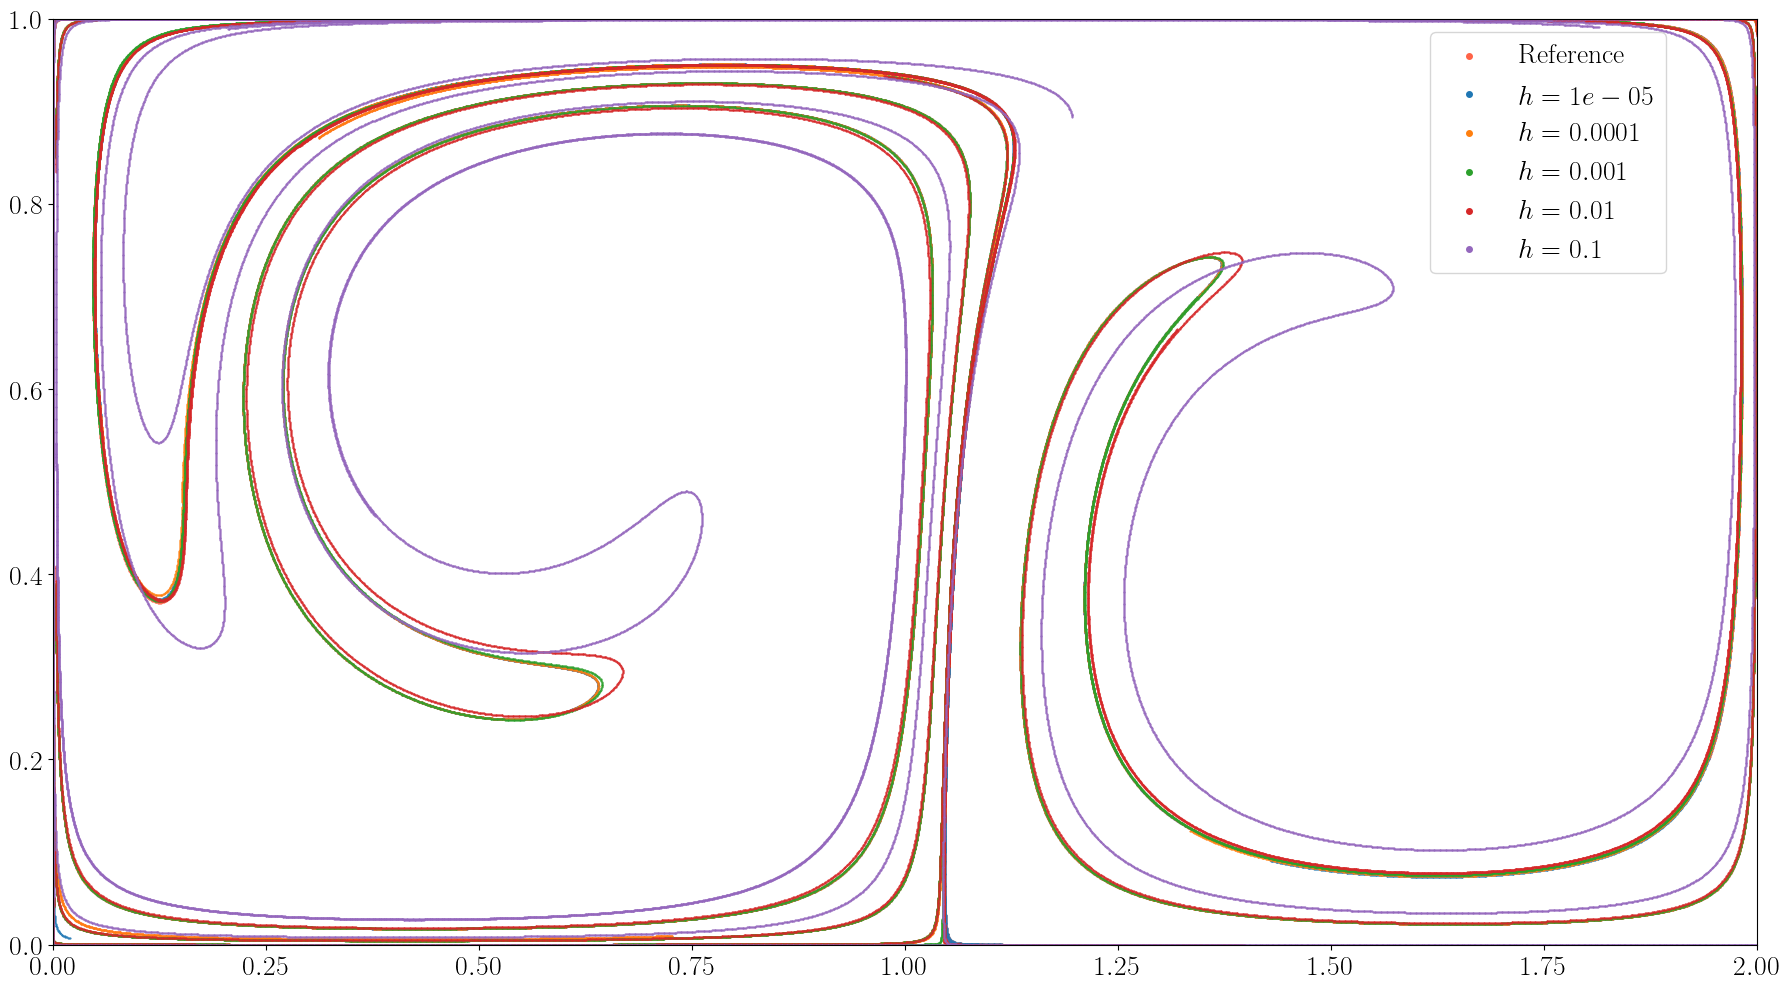

In [67]:
fig = plt.figure(1)
plot = fig.add_subplot(111)
plot.scatter(LCS_traj_ref[0],LCS_traj_ref[1],s=1,marker='.',c='tomato',label=r'Reference')
for j in range(4,-1,-1):
    plot.scatter(trajs[j][0],trajs[j][1],s=1.,marker='.',label=r'$h={}$'.format(hs[j]))

plot.legend(bbox_to_anchor=(0.8, 1), loc='upper left', ncol=1,fontsize=20,markerscale=8)
plot.tick_params(axis='both', which='major', labelsize=20)
plot.tick_params(axis='both', which='minor', labelsize=10)
plt.xlim(0,2)
plt.ylim(0,1)
plt.tight_layout()
plt.savefig('lcs_figures/{}.pdf'.format(integrator.__name__))

## Embedded runs

In [110]:
j_int = 0
integrator = embedded_integrators[j_int]
trajs = []
for tol in tolerances[1:]:
    LCS_curr = np.load('precomputed_lcs/{}/lcs_atol={}_rtol={}_max_iter=10000_stride=0.001_l_f_max=0.2_l_min=1.0_tol_alpha=1e-06.npy'.format(integrator.__name__,tol,tol))
    trajs.append(np.hstack(([LCS.tailcut_traj() for LCS in LCS_curr])))

In [83]:
np.shape(trajs[1])

(2, 32940)

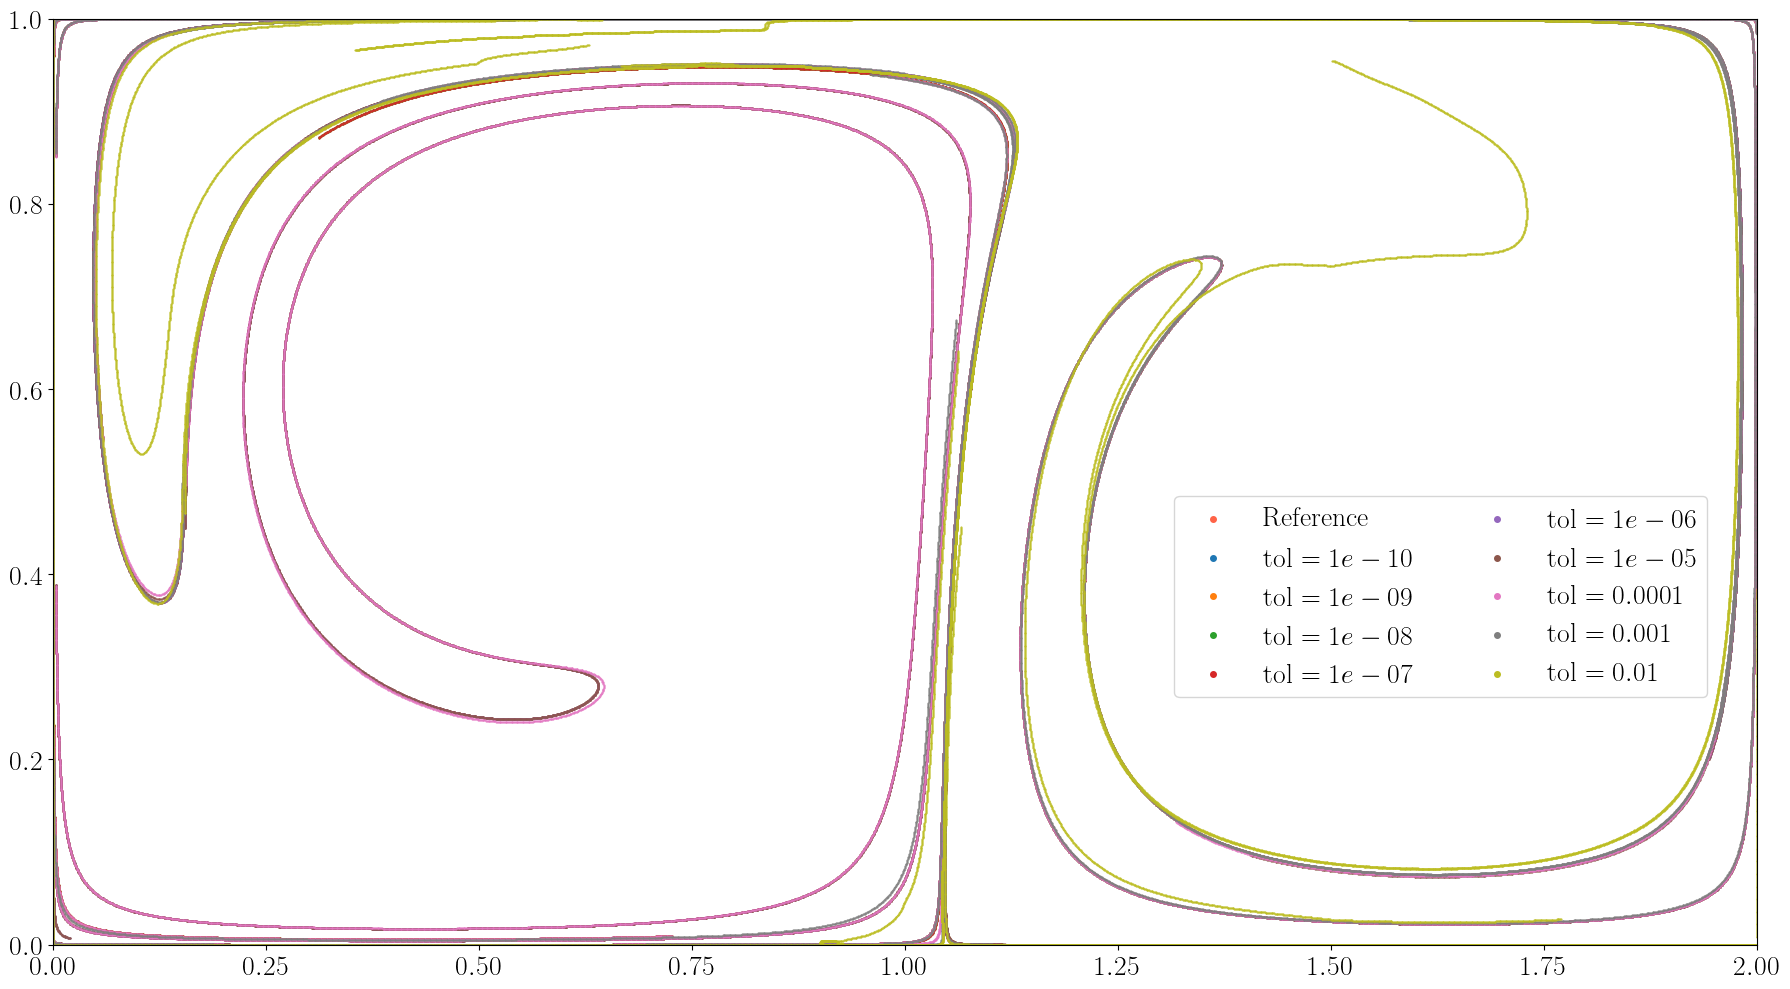

In [111]:
fig = plt.figure(1)
plot = fig.add_subplot(111)
plot.scatter(LCS_traj_ref[0],LCS_traj_ref[1],s=1,marker='.',c='tomato',label=r'Reference')
for j in range(8,-1,-1):
    plot.scatter(trajs[j][0],trajs[j][1],s=1.,marker='.',label=r'tol $={}$'.format(tolerances[j+1]))

    
plot.legend(bbox_to_anchor=(0.65, 0.5), loc='upper left', ncol=2,fontsize=20,markerscale=8)
plot.tick_params(axis='both', which='major', labelsize=20)
plot.tick_params(axis='both', which='minor', labelsize=10)
plt.xlim(0,2)
plt.ylim(0,1)
plt.tight_layout()
plt.savefig('lcs_figures/{}.pdf'.format(integrator.__name__))

In [ ]:
j_int = 0
j_sstep = 0
integrator = singlestep_integrators[j_int]

LCSs = np.load('precomputed_lcs/{}/lcs_h={}_max_iter=10000_stride=0.001_l_f_max=0.2_l_min=1.0_tol_alpha=1e-06.npy'.format(integrator.__name__,hs[j_sstep]))

In [118]:
def find_ab_mask(lmbd1,lmbd2,hess_lmbd2,xi2):
    return np.logical_and(_a_true(lmbd1,lmbd2),_b_true(hess_lmbd2,xi2))

def _a_true(lmbd1,lmbd2):
    return np.logical_and(np.less(lmbd1,lmbd2),np.greater(lmbd2,1))

def _b_true(hess_lmbd2,xi2):
    #tf = np.zeros(hess_lmbd2.shape[0],dtype=np.bool)
    #for j in range(len(tf)):
    #    if np.dot(xi2[j],np.dot(hess_lmbd2[j],xi2[j])) <=0:
    #        tf[j] = True
    #return tf
    return np.less_equal(np.sum(xi2*np.sum(hess_lmbd2*xi2[...,np.newaxis],axis=1),axis=1),0)

Precomputed advection found! Advection not necessary!
Characteristics calculated in 0.0 minutes and 3.1935977935791016 seconds


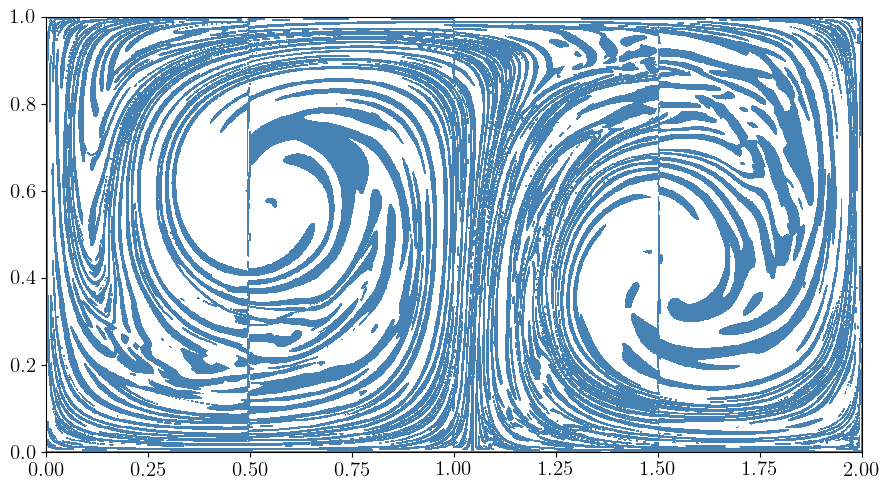

In [148]:
tolz = 1e-1

j_int = 3
integrator = embedded_integrators[j_int]

gf,lf1,lf2,hl2,xf1,xf2 = characteristics(t_start,t_end,nx,ny,x_min,x_max,y_min,y_max,integrator,stride=0.1,n_proc=4,atol=tolz,rtol=tolz)

msk_ba = find_ab_mask(lf1,lf2,hl2,xf2)

g = padded_grid_of_particles(nx,ny,x_min,x_max,y_min,y_max).reshape((2,nx+4,ny+4))[:,2:-2,2:-2].reshape((2,nx*ny))

fig = plt.figure(1,figsize=(9,5))
plot = fig.add_subplot(111)

cm = mpl.colors.ListedColormap(['white','steelblue'])

plot.contourf(g.reshape(2,nx,ny)[0,:,0],g.reshape(2,nx,ny)[1,0,:],msk_ba.reshape(nx,ny).T,cmap=cm)

#plt.scatter(g0[0],g0[1],c='k',s=1,marker='.')
plot.tick_params(axis='both', which='major', labelsize=15)
plot.tick_params(axis='both', which='minor', labelsize=7.5)
plot.set_xlim(0,2)
plot.set_ylim(0,1)
plt.tight_layout()
plt.savefig('domain_figures/{}_tol={}.png'.format(integrator.__name__,tolz),dpi=500)

In [130]:
integrator

<function numerical_integrators.adaptive_step.rkbs32>

In [ ]:
traj_ref = np.hstack(([LCS.tailcut_traj() for LCS in LCSs_ref]))

In [ ]:
traj_inv = np.hstack(([LCS.tailcut_traj() for LCS in LCSs]))

In [ ]:
trajerrinpos = np.mean([np.min(np.sqrt((traj_inv[0,j]-traj_ref[0])**2+(traj_inv[1,j]-traj_ref[1])**2))for j in range(traj_inv.shape[1])])

In [ ]:
trajerrinpos

In [ ]:
#dct = {0: 1, 1: 0, 2: 3, 3: 4: 6}

In [ ]:
print(LCSs_ref[j_lcs_ref].traj().shape)
print(LCSs[j_lcs_cur].traj().shape)

In [ ]:
plt.scatter(traj_ref[0],traj_ref[1],s=1,marker='.',c='steelblue')

In [ ]:
print(LCSs_ref[j_lcs_ref].traj()[:,LCSs_ref[j_lcs_ref].startpoint_index])
print(LCSs[j_lcs_cur].traj()[:,LCSs[j_lcs_cur].startpoint_index])

In [ ]:
for LCS in LCSs:
    plt.scatter(LCS.tailcut_traj()[0],LCS.tailcut_traj()[1],s=1,marker='.',c='steelblue')
plt.xlim(-0.02,2.02)
plt.ylim(-0.01,1.01)

In [ ]:
for LCS in LCSs_ref:
    plt.scatter(LCS.tailcut_traj()[0],LCS.tailcut_traj()[1],s=1,marker='.',c='tomato')
plt.xlim(-0.02,2.02)
plt.ylim(-0.01,1.01)

## Embedded runs

In [ ]:
plt.semilogy(embedded_calls[integrator.__name__],lmbd2_err,marker='o')
plt.semilogy(embedded_calls[rkbs32.__name__],np.load('errors/{}/lmbd2_errs.npy'.format(rkbs32.__name__)),marker='o')

In [ ]:
lmbd1_err

In [ ]:
plt.loglog(hs,lmbd1_err)

# Error in advection

In [196]:
singlestep_adv_errs = [np.load('errors/{}/adv_errs.npy'.format(integrator.__name__)) for integrator in singlestep_integrators]
embedded_adv_errs = [np.load('errors/{}/adv_errs.npy'.format(integrator.__name__)) for integrator in embedded_integrators]

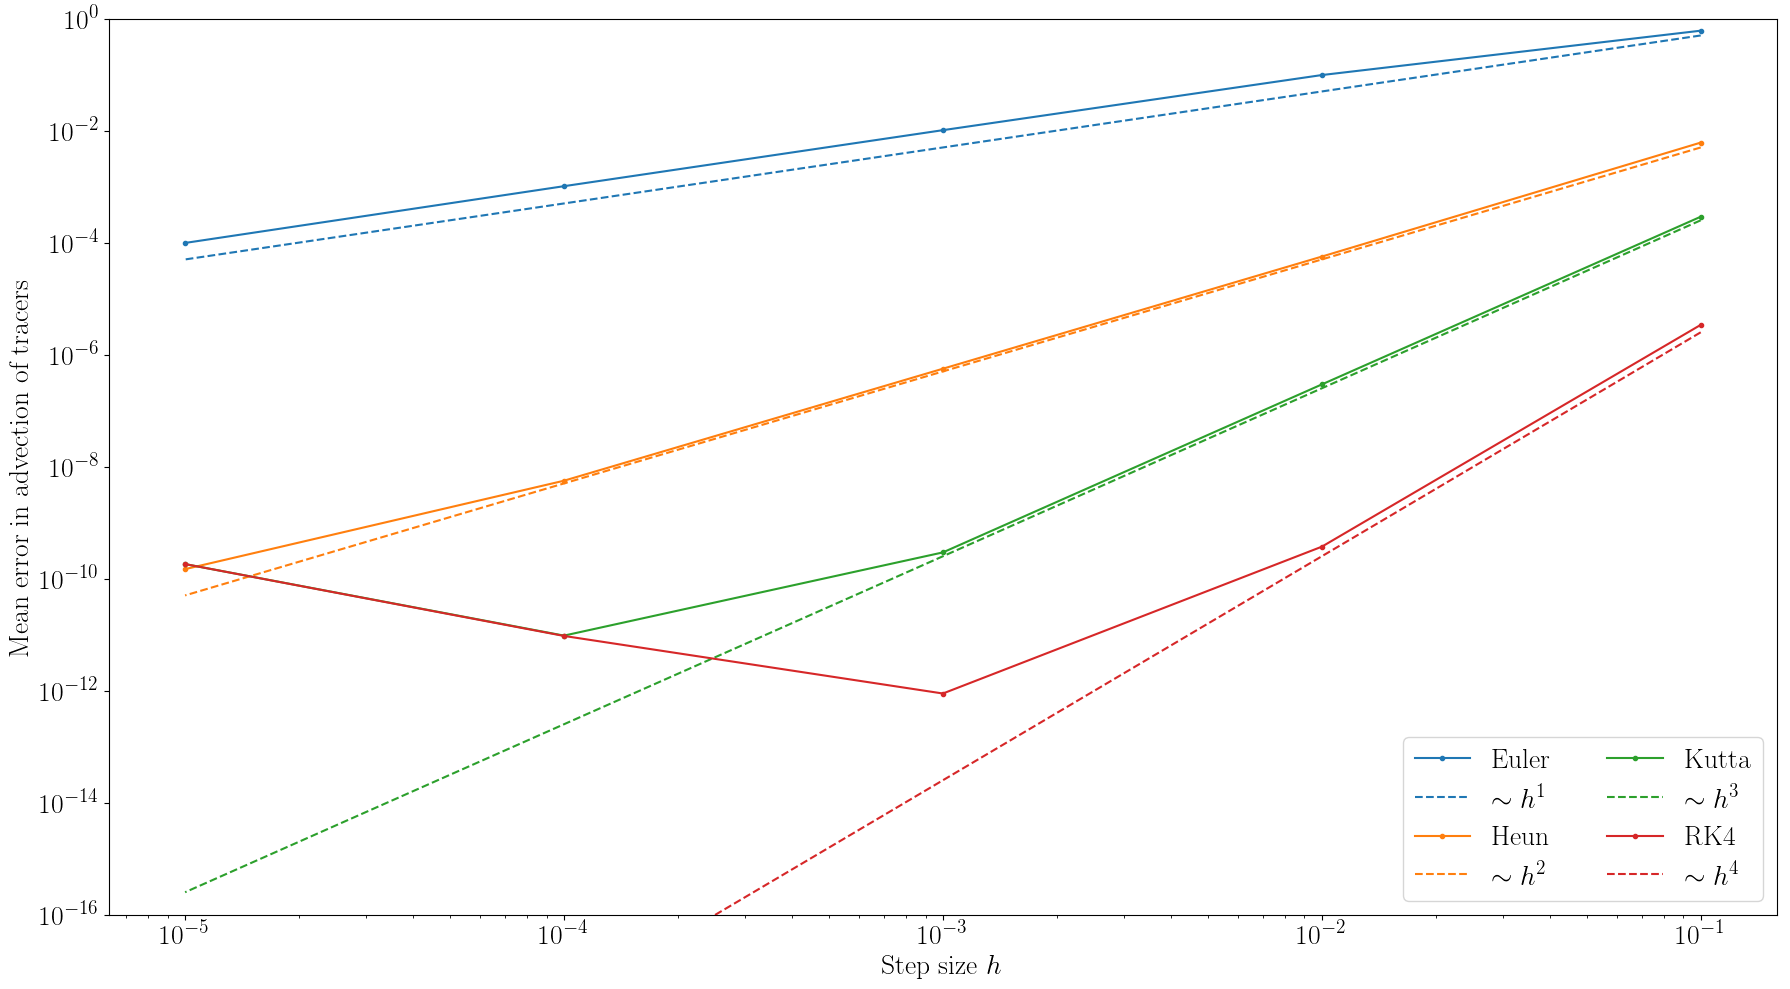

In [185]:
fig = plt.figure(1)
plot = fig.add_subplot(111)

names = ['Euler','Heun','Kutta','RK4']
scales = [5e0,5e-1,2.5e-1,2.5e-2]

for j,err in enumerate(singlestep_adv_errs):
    l,=plot.plot(hs,err,marker='.',label='{}'.format(names[j]))
    plot.plot(hs,scales[j]*hs**(j+1),'--',c=l.get_color(),label=r'$\sim h^{}$'.format(j+1))
    
plot.tick_params(axis='both', which='major', labelsize=20)
plot.tick_params(axis='both', which='minor', labelsize=10)
plot.set_yscale('log')
plot.set_xscale('log')
plot.set_ylim(1e-16,1)
plot.legend(loc='lower right', ncol=2,fontsize=20,markerscale=1)
plot.set_xlabel(r'Step size $h$',fontsize=20)
plot.set_ylabel(r'Mean error in advection of tracers',fontsize=20)
plt.tight_layout()
plt.savefig('error_plots/advection_errors_fixed_steplength.pdf')

In [186]:
singlestep_evaluations = [np.load('errors/{}/evaluations.npy'.format(integrator.__name__)) for integrator in singlestep_integrators]
embedded_evaluations = [np.load('errors/{}/evaluations.npy'.format(integrator.__name__)) for integrator in embedded_integrators]

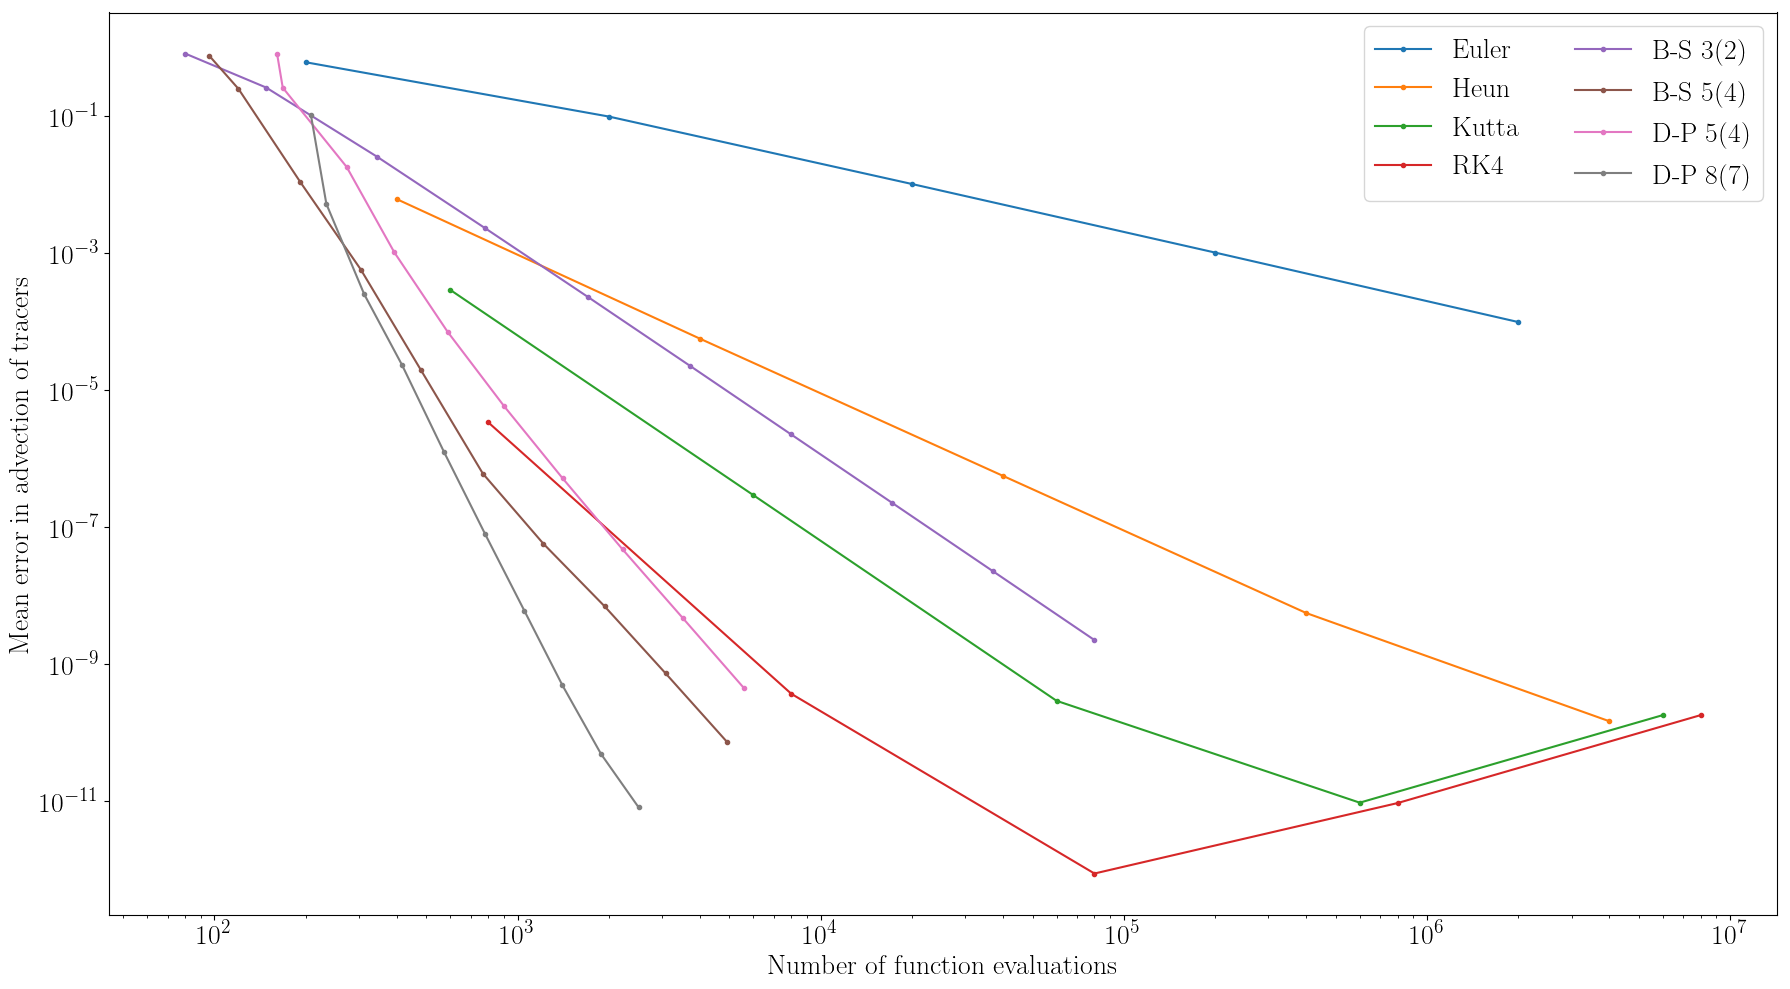

In [200]:
fig = plt.figure(1)
plot = fig.add_subplot(111)

snames = ['Euler','Heun','Kutta','RK4']
enames = ['B-S 3(2)','B-S 5(4)','D-P 5(4)','D-P 8(7)']

for j,(evs,err) in enumerate(zip(singlestep_evaluations,singlestep_adv_errs)):
    plot.plot(evs,err,marker='.',label='{}'.format(snames[j]))
for j,(evs,err) in enumerate(zip(embedded_evaluations,embedded_adv_errs)):
    plot.plot(evs,err,marker='.',label='{}'.format(enames[j]))

    #plot.plot(hs,scales[j]*hs**(j+1),'--',c=l.get_color(),label=r'$\sim h^{}$'.format(j+1))
    
plot.tick_params(axis='both', which='major', labelsize=20)
plot.tick_params(axis='both', which='minor', labelsize=10)
plot.set_yscale('log')
plot.set_xscale('log')
#plot.set_ylim(1e-16,1)
plot.legend(loc='best', ncol=2,fontsize=20,markerscale=1)
plot.set_xlabel(r'Number of function evaluations',fontsize=20)
plot.set_ylabel(r'Mean error in advection of tracers',fontsize=20)
plt.tight_layout()
plt.savefig('error_plots/advection_errors_fixed_and_adaptive_steplength.pdf')

# Error in $\lambda_{1}$

In [201]:
singlestep_lmbd1_errs = [np.load('errors/{}/lmbd1_errs.npy'.format(integrator.__name__)) for integrator in singlestep_integrators]
embedded_lmbd1_errs = [np.load('errors/{}/lmbd1_errs.npy'.format(integrator.__name__)) for integrator in embedded_integrators]

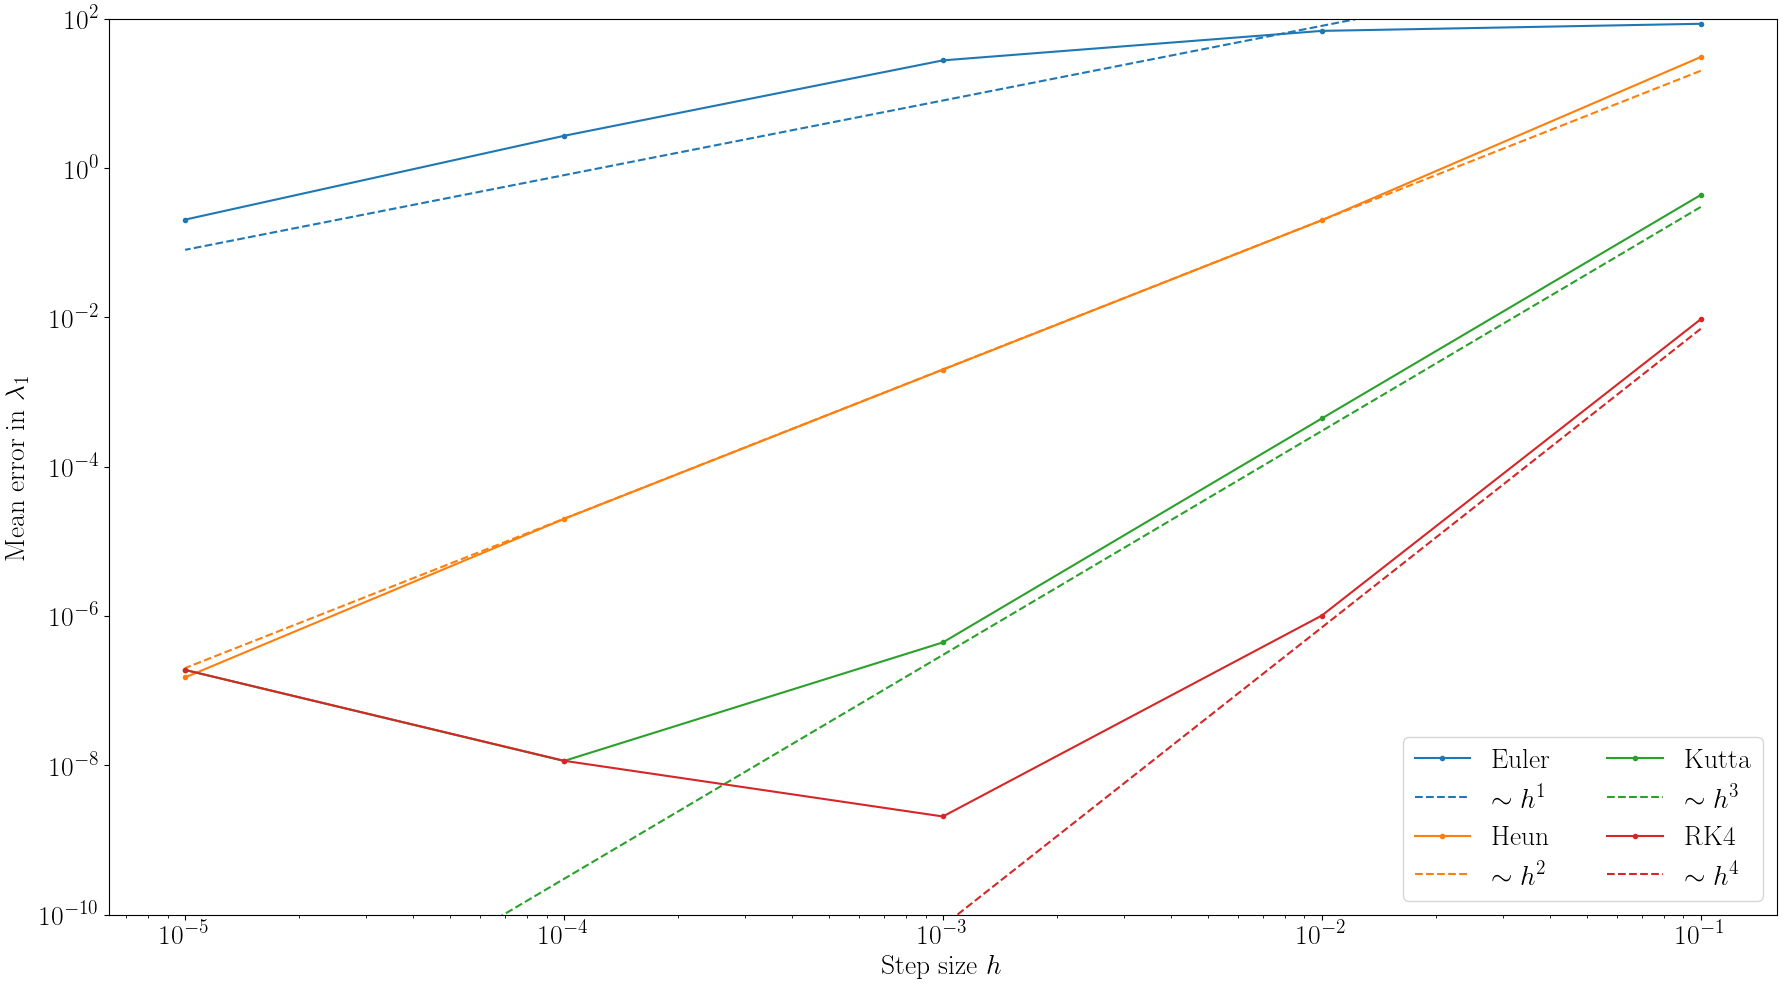

In [268]:
fig = plt.figure(1)
plot = fig.add_subplot(111)

names = ['Euler','Heun','Kutta','RK4']
scales = [8e3,2e3,3e2,7e1]

for j,err in enumerate(singlestep_lmbd1_errs):
    l,=plot.plot(hs,err,marker='.',label='{}'.format(names[j]))
    plot.plot(hs,scales[j]*hs**(j+1),'--',c=l.get_color(),label=r'$\sim h^{}$'.format(j+1))
    
plot.tick_params(axis='both', which='major', labelsize=20)
plot.tick_params(axis='both', which='minor', labelsize=10)
plot.set_yscale('log')
plot.set_xscale('log')
plot.set_ylim(1e-10,1e2)
plot.legend(loc='lower right', ncol=2,fontsize=20,markerscale=1)
plot.set_xlabel(r'Step size $h$',fontsize=20)
plot.set_ylabel(r'Mean error in $\lambda_{1}$',fontsize=20)
plt.tight_layout()
plt.savefig('error_plots/eigenvalue1_errors_fixed_steplength.png',dpi=100)

# Error in $\lambda_{2}$

In [204]:
singlestep_lmbd2_errs = [np.load('errors/{}/lmbd2_errs.npy'.format(integrator.__name__)) for integrator in singlestep_integrators]
embedded_lmbd2_errs = [np.load('errors/{}/lmbd2_errs.npy'.format(integrator.__name__)) for integrator in embedded_integrators]

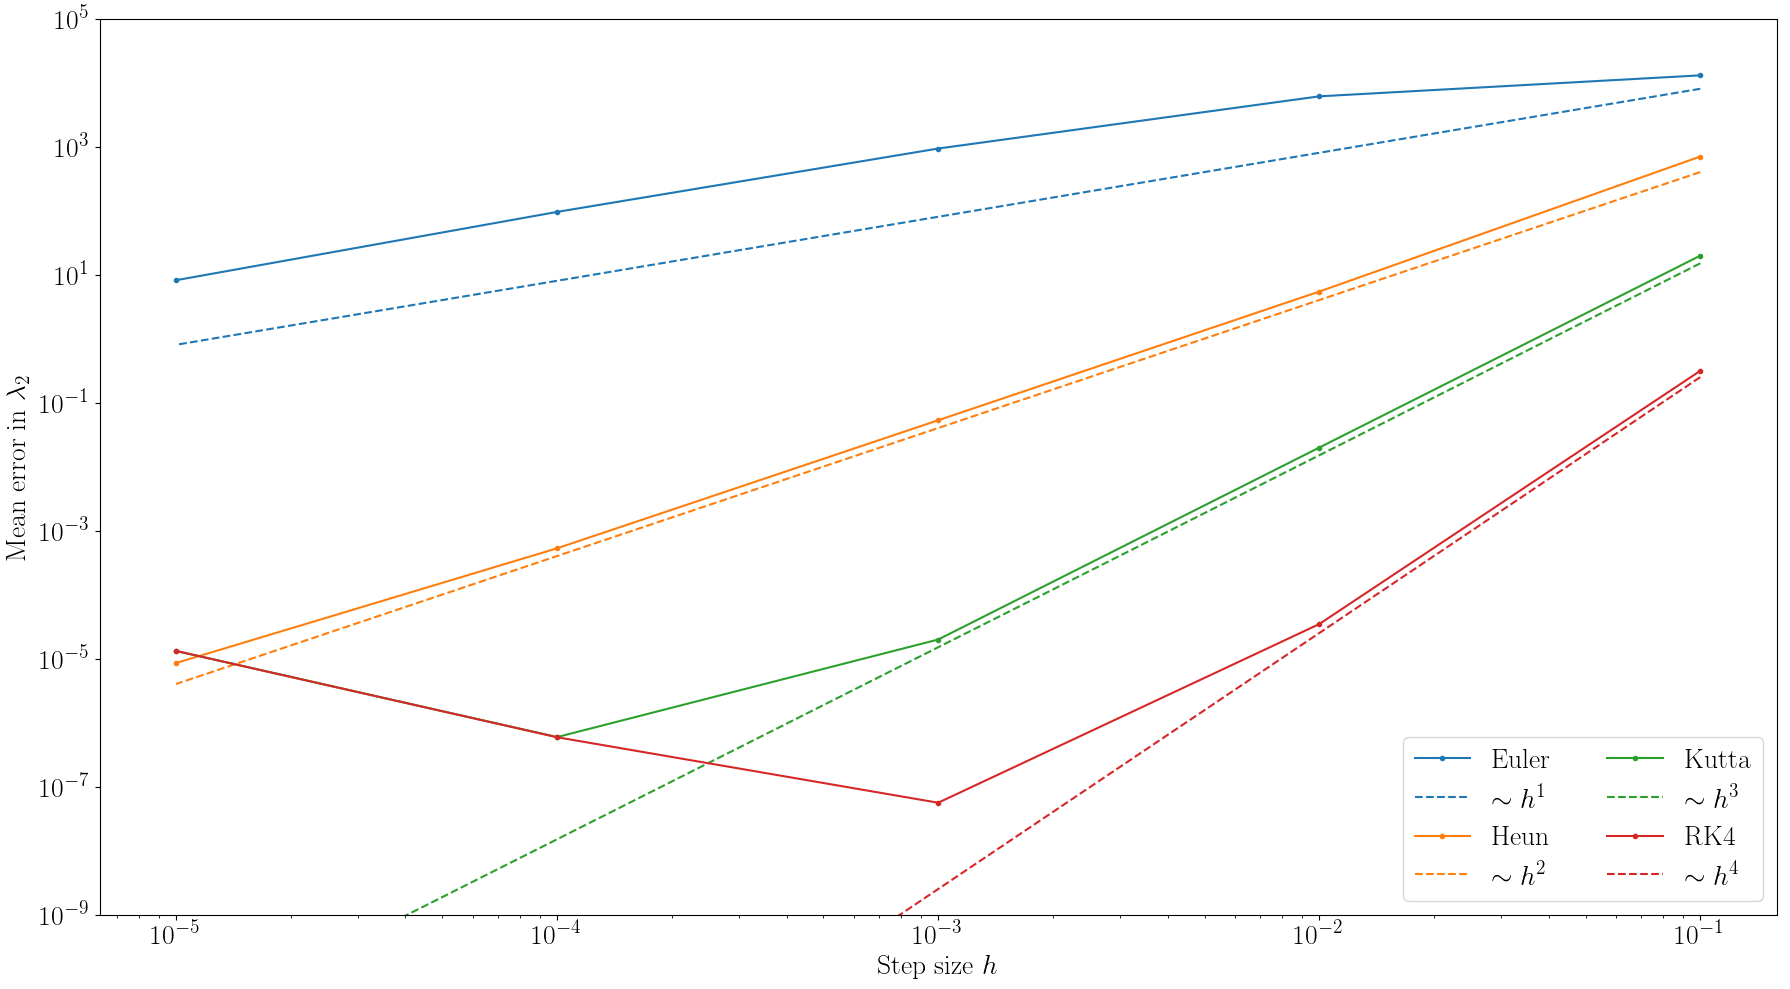

In [257]:
fig = plt.figure(1)
plot = fig.add_subplot(111)

names = ['Euler','Heun','Kutta','RK4']
scales = [8e4,4e4,1.5e4,2.5e3]

for j,err in enumerate(singlestep_lmbd2_errs):
    l,=plot.plot(hs,err,marker='.',label='{}'.format(names[j]))
    plot.plot(hs,scales[j]*hs**(j+1),'--',c=l.get_color(),label=r'$\sim h^{}$'.format(j+1))
    
plot.tick_params(axis='both', which='major', labelsize=20)
plot.tick_params(axis='both', which='minor', labelsize=10)
plot.set_yscale('log')
plot.set_xscale('log')
plot.set_ylim(1e-9,1e5)
plot.legend(loc='lower right', ncol=2,fontsize=20,markerscale=1)
plot.set_xlabel(r'Step size $h$',fontsize=20)
plot.set_ylabel(r'Mean error in $\lambda_{2}$',fontsize=20)
plt.tight_layout()
plt.savefig('error_plots/eigenvalue2_errors_fixed_steplength.png',dpi=100)

# Error in $\xi_{1}$

In [206]:
singlestep_xi1_errs = [np.load('errors/{}/xi1_errs.npy'.format(integrator.__name__)) for integrator in singlestep_integrators]
embedded_xi1_errs = [np.load('errors/{}/xi1_errs.npy'.format(integrator.__name__)) for integrator in embedded_integrators]

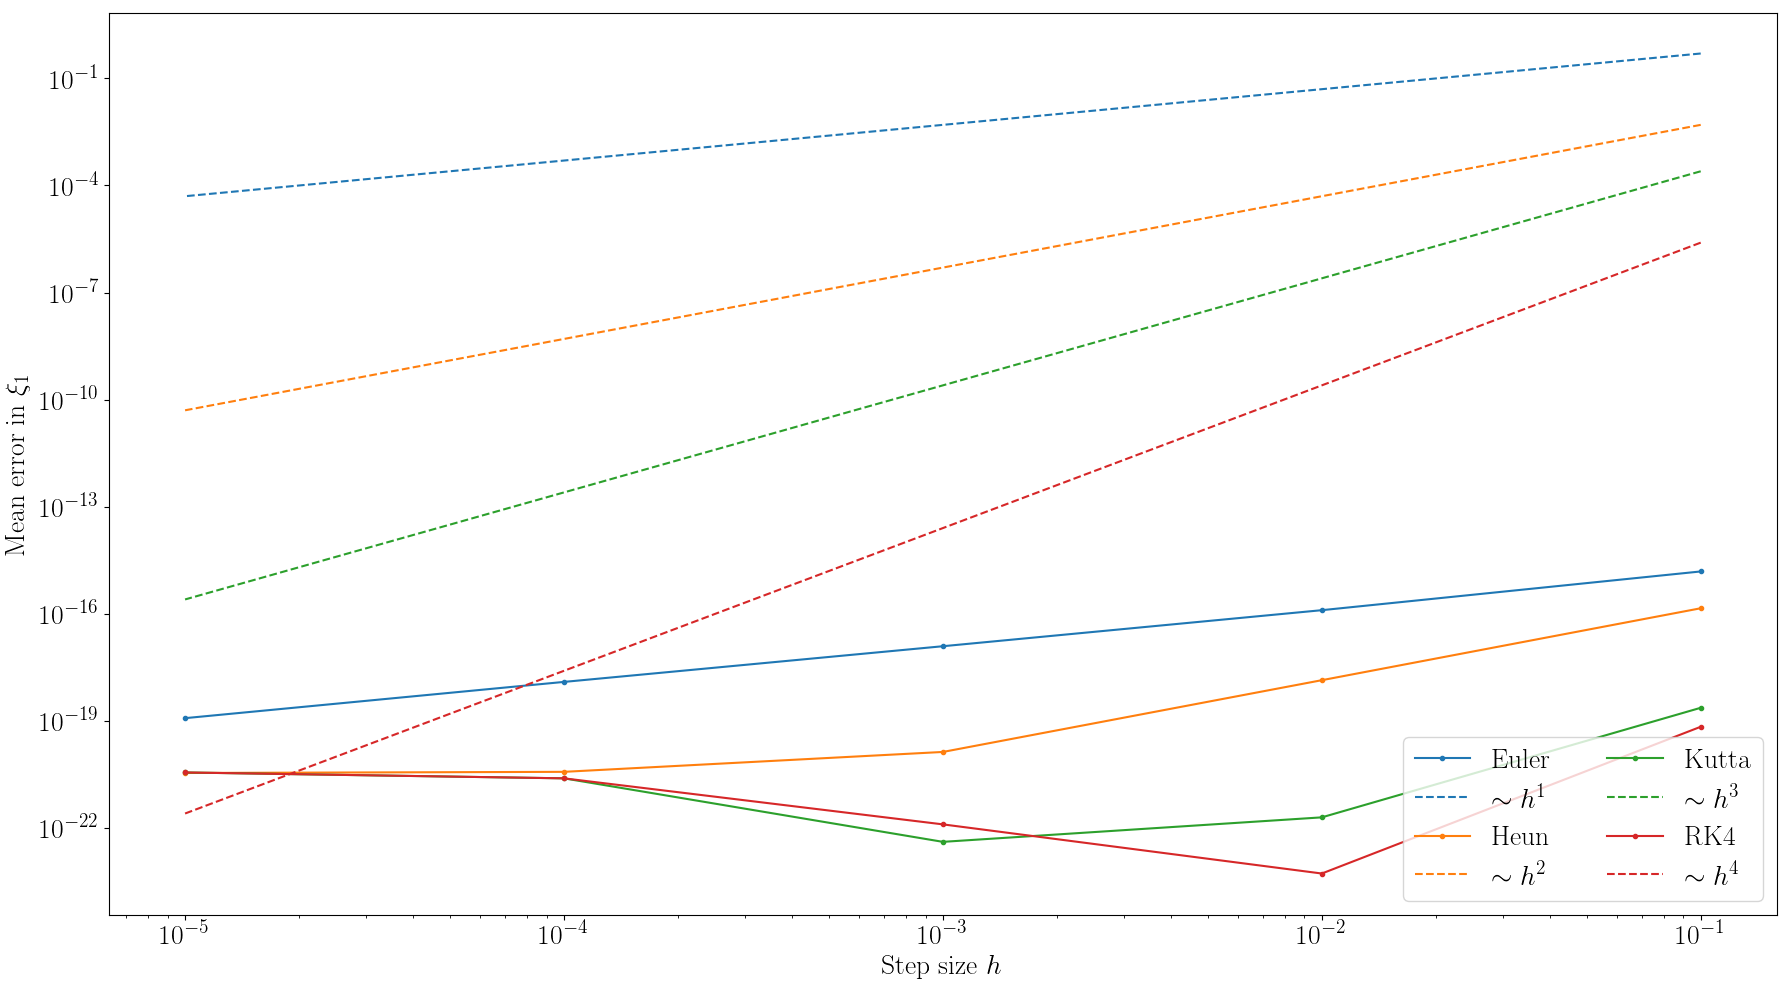

In [219]:
fig = plt.figure(1)
plot = fig.add_subplot(111)

names = ['Euler','Heun','Kutta','RK4']
scales = [5e0,5e-1,2.5e-1,2.5e-2]

for j,err in enumerate(singlestep_xi1_errs):
    l,=plot.plot(hs,err,marker='.',label='{}'.format(names[j]))
    plot.plot(hs,scales[j]*hs**(j+1),'--',c=l.get_color(),label=r'$\sim h^{}$'.format(j+1))
    
plot.tick_params(axis='both', which='major', labelsize=20)
plot.tick_params(axis='both', which='minor', labelsize=10)
plot.set_yscale('log')
plot.set_xscale('log')
#plot.set_ylim(1e-16,1)
plot.legend(loc='lower right', ncol=2,fontsize=20,markerscale=1)
plot.set_xlabel(r'Step size $h$',fontsize=20)
plot.set_ylabel(r'Mean error in $\xi_{1}$',fontsize=20)
plt.tight_layout()
#plt.savefig('error_plots/advection_errors_fixed_steplength.pdf')

# Error in $\xi_{2}$ 

In [209]:
singlestep_xi2_errs = [np.load('errors/{}/xi2_errs.npy'.format(integrator.__name__)) for integrator in singlestep_integrators]
embedded_xi2_errs = [np.load('errors/{}/xi2_errs.npy'.format(integrator.__name__)) for integrator in embedded_integrators]

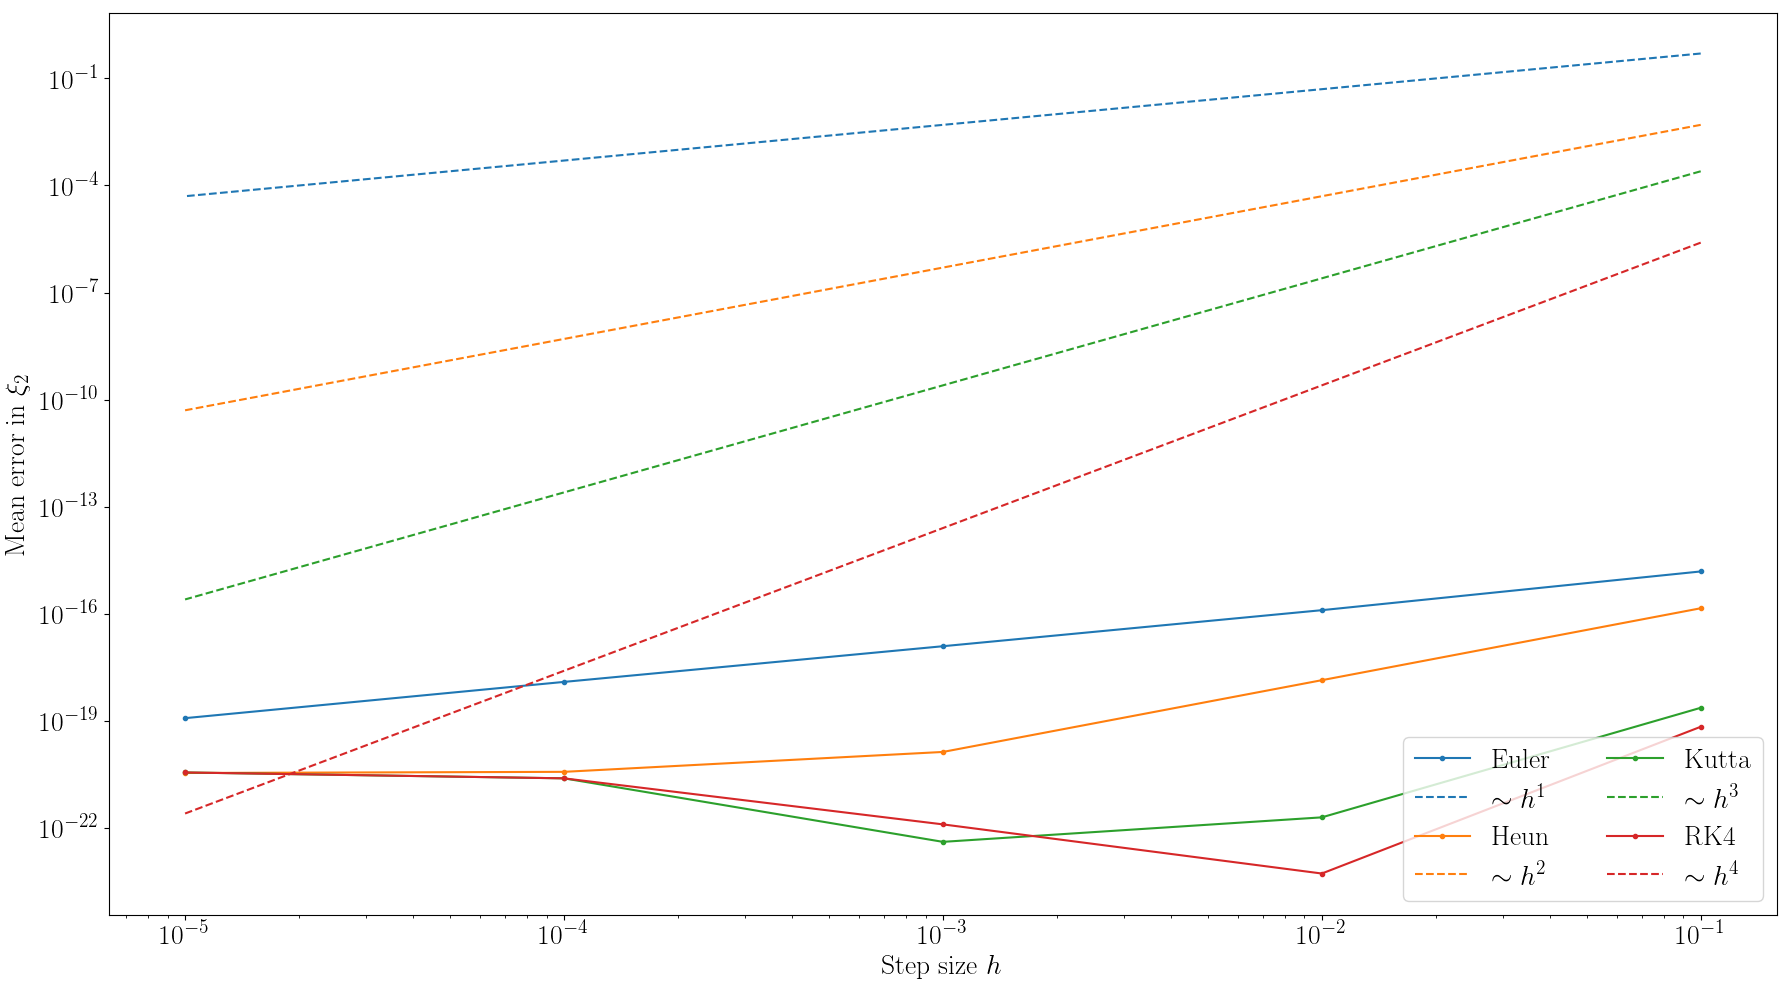

In [220]:
fig = plt.figure(1)
plot = fig.add_subplot(111)

names = ['Euler','Heun','Kutta','RK4']
scales = [5e0,5e-1,2.5e-1,2.5e-2]

for j,err in enumerate(singlestep_xi2_errs):
    l,=plot.plot(hs,err,marker='.',label='{}'.format(names[j]))
    plot.plot(hs,scales[j]*hs**(j+1),'--',c=l.get_color(),label=r'$\sim h^{}$'.format(j+1))
    
plot.tick_params(axis='both', which='major', labelsize=20)
plot.tick_params(axis='both', which='minor', labelsize=10)
plot.set_yscale('log')
plot.set_xscale('log')
#plot.set_ylim(1e-16,1)
plot.legend(loc='lower right', ncol=2,fontsize=20,markerscale=1)
plot.set_xlabel(r'Step size $h$',fontsize=20)
plot.set_ylabel(r'Mean error in $\xi_{2}$',fontsize=20)
plt.tight_layout()
#plt.savefig('error_plots/advection_errors_fixed_steplength.pdf')

In [217]:
nlmbderrs = np.empty(np.shape(singlestep_lmbd1_errs))
for j in range(4):
    nlmbderrs[j] = [np.mean([singlestep_lmbd1_errs[j][i],singlestep_lmbd2_errs[j][i]]) for i in range(singlestep_lmbd1_errs[j].shape[0])]

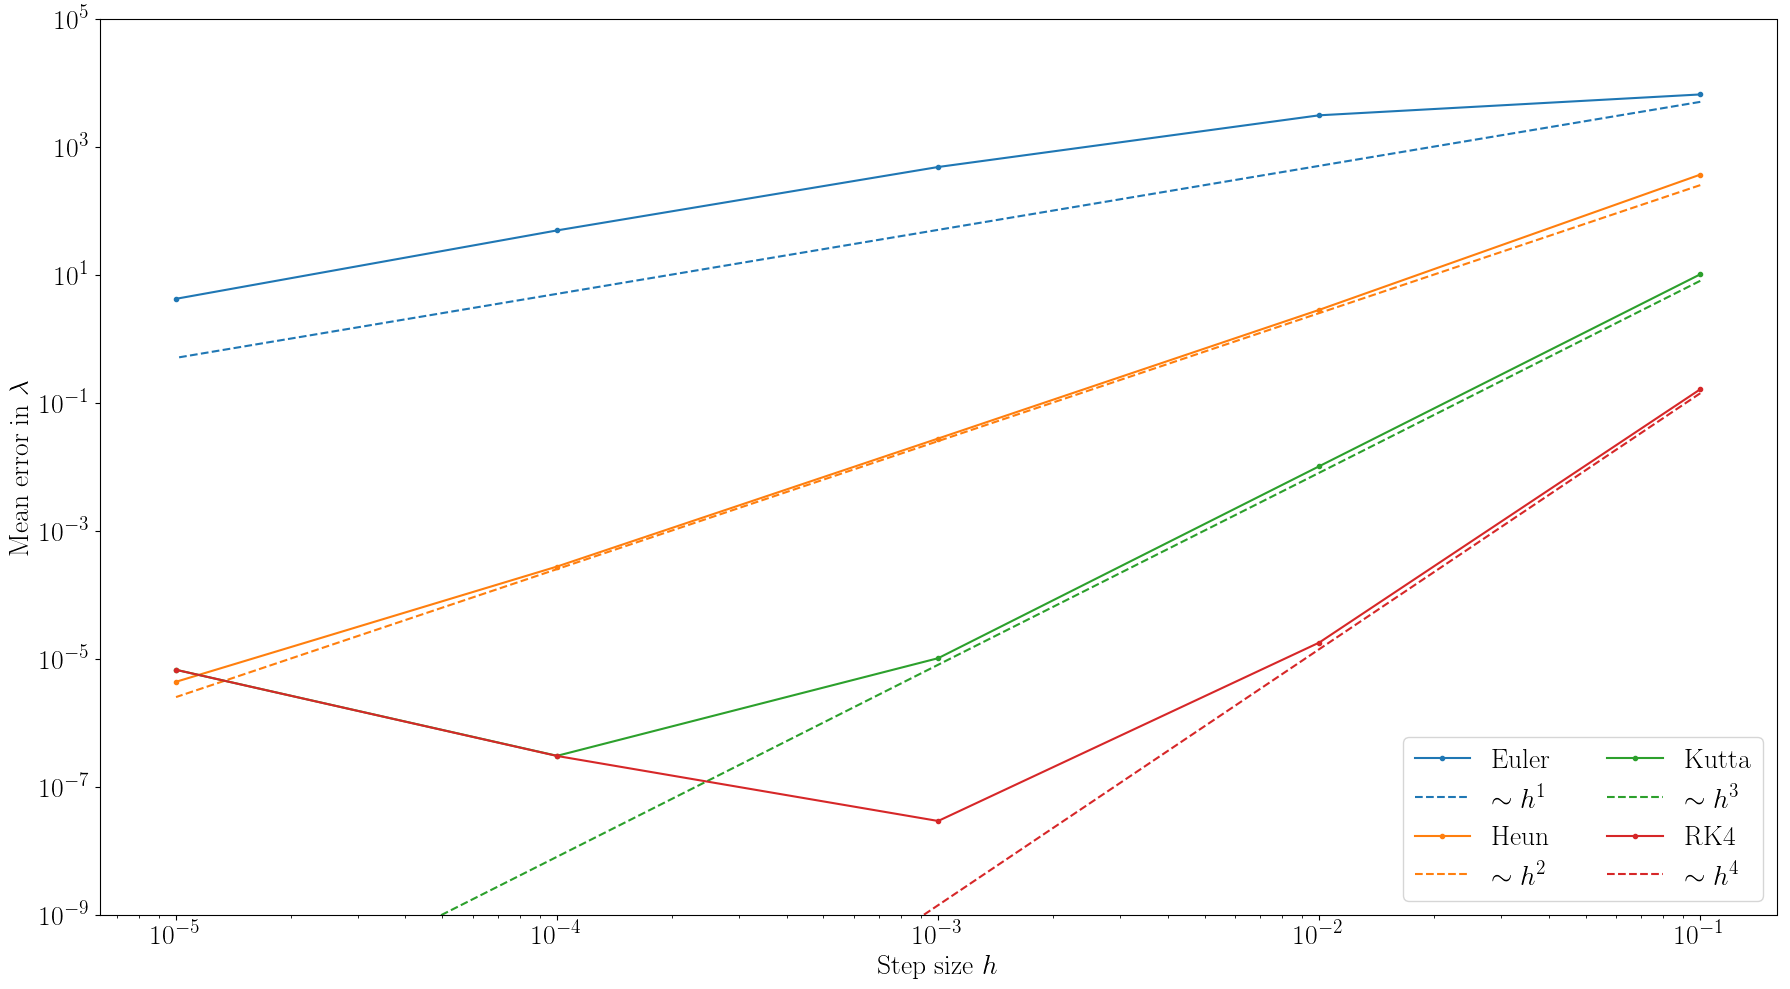

In [244]:
fig = plt.figure(1)
plot = fig.add_subplot(111)

names = ['Euler','Heun','Kutta','RK4']
scales = [5e4,2.5e4,8e3,1.4e3]

for j,err in enumerate(nlmbderrs):
    l,=plot.plot(hs,err,marker='.',label='{}'.format(names[j]))
    plot.plot(hs,scales[j]*hs**(j+1),'--',c=l.get_color(),label=r'$\sim h^{}$'.format(j+1))
    
plot.tick_params(axis='both', which='major', labelsize=20)
plot.tick_params(axis='both', which='minor', labelsize=10)
plot.set_yscale('log')
plot.set_xscale('log')
plot.set_ylim(1e-9,1e5)
plot.legend(loc='lower right', ncol=2,fontsize=20,markerscale=1)
plot.set_xlabel(r'Step size $h$',fontsize=20)
plot.set_ylabel(r'Mean error in $\lambda$',fontsize=20)
plt.tight_layout()
plt.savefig('error_plots/eigenvalue_errors_fixed_steplength.png',dpi=100)